# Long Short Term Memory (LSTM) with Keras (2)

LSTMs (RNNs in general) are also very suited to time series prediction due to their keeping track of hidden state.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,14)

Using TensorFlow backend.


#### Configuration

In [4]:
num_epochs = 50

model_exists = False
model_name = "inet_traffic.h5"

lstm_num_timesteps = 4 # for diffed series
effective_timesteps = lstm_num_timesteps+1
lstm_num_features = 1

num_neurons = 4
batchsize = 1


We will analyze time series data downloaded from https://datamarket.com/data/set/232j. 
These are internet traffic data collected on an hourly basis.

In [5]:
# 
# Internet traffic data (in bits) from a private ISP with centres in 11 European cities. 
# The data corresponds to a transatlantic link 
# and was collected from 06:57 hours on 7 June to 11:17 hours on 31 July 2005. 
# Hourly data. 

series = pd.read_csv('internet-traffic-data-in-bits-fr.csv', header = None, index_col=0, squeeze = True, 
                     parse_dates = True, dtype="float64")
print(len(series))
print(series.head())

1231
0
2005-06-07 07:00:00    5.671859e+10
2005-06-07 08:00:00    7.645616e+10
2005-06-07 09:00:00    8.253404e+10
2005-06-07 10:00:00    8.879700e+10
2005-06-07 11:00:00    9.024792e+10
Name: 1, dtype: float64


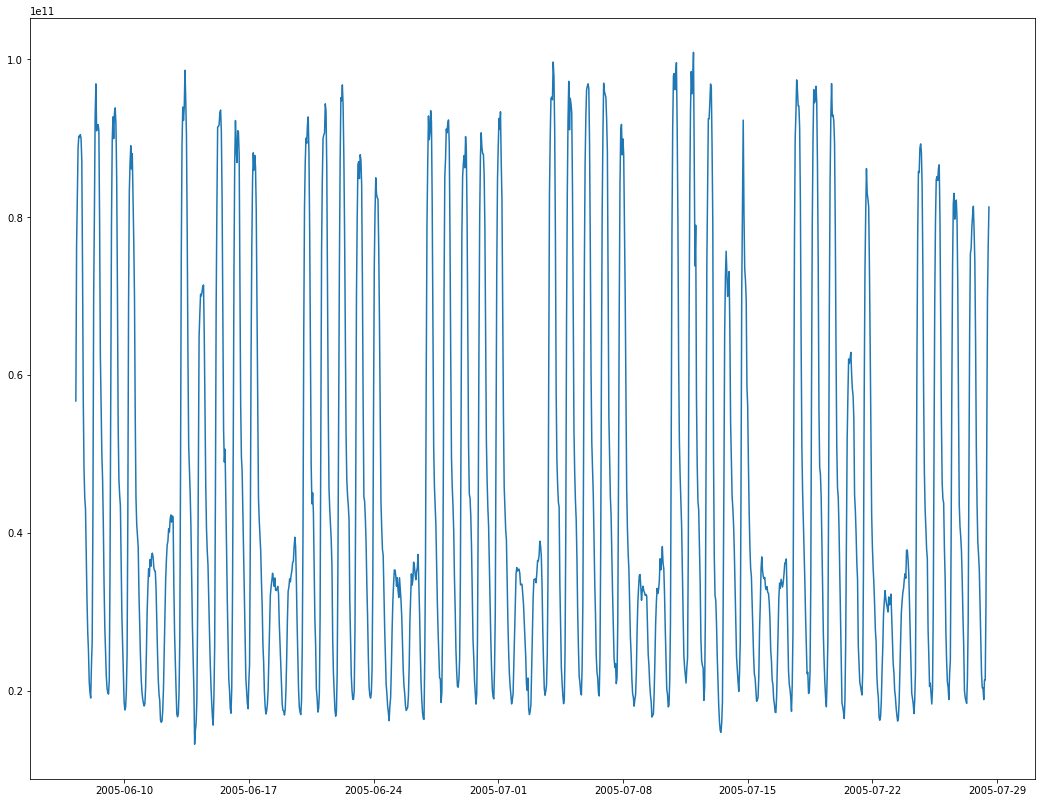

In [6]:
# we have a mix of different periodicities here, this is difficult for classical algorithms
plt.plot(series)

We first split the data into training and test.

In [7]:
train_data = series.values[:800]
test_data = series.values[800:]
train_data[:10]

array([  5.67185874e+10,   7.64561630e+10,   8.25340385e+10,
         8.87969951e+10,   9.02479223e+10,   9.01461171e+10,
         9.04574107e+10,   8.99676609e+10,   8.72117422e+10,
         7.36106348e+10])

### Preprocessing

We are going to preprocess the time series data as follows:

1) difference (use the successive differences for calculation)

2) scale to values between -1 and 1 (to match the LSTM's tanh activation)

#### Difference

In [8]:
# for differencing, can just use np.diff

# to invert differences for predictions
def undiff(preds, series, num_timesteps):
    # zero-based indexing! 
    # add predictions to all target elements from original series
    return preds + series[num_timesteps:(len(series)-1)]
                          

In [9]:
# differencing example 
toy_num_timesteps = 3 
toy_X = np.array([1,3,5,7,9,11,13])
print(toy_X)

toy_X_diff = np.diff(toy_X)
print(toy_X_diff)

toy_preds = np.array([2.1,2.1,2.1]) # 3 predictions, because working on diffed data

# this adds elements 3,4,5 (with zero-based indexing - otherwise 4,5,6) from the original series to the predictions
toy_X_undiff = undiff(toy_preds, toy_X, toy_num_timesteps) 
toy_X_undiff

[ 1  3  5  7  9 11 13]
[2 2 2 2 2 2]


array([  9.1,  11.1,  13.1])

In [10]:
train_diff = np.diff(train_data)
test_diff = np.diff(test_data)
train_diff[:10]

array([  1.97375755e+10,   6.07787552e+09,   6.26295661e+09,
         1.45092725e+09,  -1.01805228e+08,   3.11293556e+08,
        -4.89749814e+08,  -2.75591861e+09,  -1.36011074e+10,
        -1.69153086e+10])

#### Scale

In [11]:
# first, reshapes the data to 2 dims
train_diff = train_diff.reshape(-1,1)
test_diff = test_diff.reshape(-1,1)

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_diff)
train_scaled = scaler.transform(train_diff)
test_scaled = scaler.transform(test_diff)

In [13]:
scaler.data_min_, scaler.data_max_

(array([ -1.97193885e+10]), array([  2.76819988e+10]))

In [14]:
train_scaled[:10]

array([[ 0.66480208],
       [ 0.08846029],
       [ 0.0962694 ],
       [-0.10676388],
       [-0.1722781 ],
       [-0.15484828],
       [-0.18864659],
       [-0.28426273],
       [-0.74185224],
       [-0.88168786]])

#### Next, we need to transform the training data into a timesteps form.

In [15]:
# function from http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [16]:
# demonstrate the function
values = [x for x in range(10)]
data = series_to_supervised(values,3)
print(data.values)

[[ 0.  1.  2.  3.]
 [ 1.  2.  3.  4.]
 [ 2.  3.  4.  5.]
 [ 3.  4.  5.  6.]
 [ 4.  5.  6.  7.]
 [ 5.  6.  7.  8.]
 [ 6.  7.  8.  9.]]


In [17]:
train_matrix = series_to_supervised(train_scaled,lstm_num_timesteps).values
test_matrix = series_to_supervised(test_scaled,lstm_num_timesteps).values
train_matrix[:10,:]

array([[ 0.66480208,  0.08846029,  0.0962694 , -0.10676388, -0.1722781 ],
       [ 0.08846029,  0.0962694 , -0.10676388, -0.1722781 , -0.15484828],
       [ 0.0962694 , -0.10676388, -0.1722781 , -0.15484828, -0.18864659],
       [-0.10676388, -0.1722781 , -0.15484828, -0.18864659, -0.28426273],
       [-0.1722781 , -0.15484828, -0.18864659, -0.28426273, -0.74185224],
       [-0.15484828, -0.18864659, -0.28426273, -0.74185224, -0.88168786],
       [-0.18864659, -0.28426273, -0.74185224, -0.88168786, -0.5301967 ],
       [-0.28426273, -0.74185224, -0.88168786, -0.5301967 , -0.32425331],
       [-0.74185224, -0.88168786, -0.5301967 , -0.32425331, -0.22522484],
       [-0.88168786, -0.5301967 , -0.32425331, -0.22522484, -0.4248819 ]])

Split off the last column as target value (y):

In [18]:
X_train, y_train = train_matrix[:, 0:-1], train_matrix[:, -1]
X_test, y_test = test_matrix[:, 0:-1], test_matrix[:, -1]
X_train[:3,:], y_train[:3]

(array([[ 0.66480208,  0.08846029,  0.0962694 , -0.10676388],
        [ 0.08846029,  0.0962694 , -0.10676388, -0.1722781 ],
        [ 0.0962694 , -0.10676388, -0.1722781 , -0.15484828]]),
 array([-0.1722781 , -0.15484828, -0.18864659]))

Finally, convert the data to the form expected by LSTM:

In [19]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], lstm_num_timesteps, lstm_num_features))
X_test = np.reshape(X_test, (X_test.shape[0], lstm_num_timesteps, lstm_num_features))

In [20]:
# now create the model
model = Sequential()
model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batchsize, verbose=1, shuffle=True)

Epoch 1/50
795/795 [==============================] - 1s - loss: 0.0847     
Epoch 2/50
795/795 [==============================] - 1s - loss: 0.0631     
Epoch 3/50
795/795 [==============================] - 1s - loss: 0.0496     
Epoch 4/50
795/795 [==============================] - 1s - loss: 0.0366     
Epoch 5/50
795/795 [==============================] - 1s - loss: 0.0309     
Epoch 6/50
795/795 [==============================] - 1s - loss: 0.0281     
Epoch 7/50
795/795 [==============================] - 1s - loss: 0.0268     
Epoch 8/50
795/795 [==============================] - 1s - loss: 0.0259     
Epoch 9/50
795/795 [==============================] - 1s - loss: 0.0250     
Epoch 10/50
795/795 [==============================] - 1s - loss: 0.0242     
Epoch 11/50
795/795 [==============================] - 1s - loss: 0.0232     
Epoch 12/50
795/795 [==============================] - 1s - loss: 0.0223     
Epoch 13/50
795/795 [==============================] - 1s - loss: 0.0216 

In [22]:
train_predictions_raw = model.predict(X_train, batch_size = 1)
train_predictions_raw[:10]

array([[-0.1668773 ],
       [-0.20546326],
       [-0.25619611],
       [-0.25856596],
       [-0.40133366],
       [-0.86675292],
       [-0.6661557 ],
       [-0.31992903],
       [-0.32518467],
       [-0.32017779]], dtype=float32)

In [23]:
train_predictions_unscaled = scaler.inverse_transform(train_predictions_raw)
train_predictions_unscaled[:10]

array([[  2.61974120e+07],
       [ -8.88316672e+08],
       [ -2.09072038e+09],
       [ -2.14688742e+09],
       [ -5.53058099e+09],
       [ -1.65613404e+10],
       [ -1.18070467e+10],
       [ -3.60123494e+09],
       [ -3.72579738e+09],
       [ -3.60713088e+09]], dtype=float32)

In [24]:
# remove second dimension, for undifferencing
train_predictions_unscaled = train_predictions_unscaled.reshape(train_predictions_unscaled.shape[0],)
train_predictions_unscaled[:10]

array([  2.61974120e+07,  -8.88316672e+08,  -2.09072038e+09,
        -2.14688742e+09,  -5.53058099e+09,  -1.65613404e+10,
        -1.18070467e+10,  -3.60123494e+09,  -3.72579738e+09,
        -3.60713088e+09], dtype=float32)

In [25]:
len(train_predictions_unscaled)
train_predictions_undiffed = undiff(train_predictions_unscaled, train_data, lstm_num_timesteps)
train_predictions = train_predictions_undiffed
train_predictions[:10]

array([  9.02741198e+10,   8.92578004e+10,   8.83666903e+10,
         8.78207734e+10,   8.16811613e+10,   5.70492944e+10,
         4.48882796e+10,   4.45093669e+10,   4.06810814e+10,
         3.94430682e+10])

In [26]:
test_predictions_raw = model.predict(X_test, batch_size = 1)
test_predictions_unscaled = scaler.inverse_transform(test_predictions_raw)
test_predictions_unscaled = test_predictions_unscaled.reshape(test_predictions_unscaled.shape[0],)
test_predictions_undiffed = undiff(test_predictions_unscaled, test_data, lstm_num_timesteps)
test_predictions = test_predictions_undiffed
test_predictions[:10]

array([  9.70227912e+10,   9.97779545e+10,   9.88003851e+10,
         9.55118550e+10,   9.70578666e+10,   1.02154713e+11,
         7.82602604e+10,   6.43686242e+10,   4.92673574e+10,
         4.77912000e+10])

In [27]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    padding = [np.nan for i in range(effective_timesteps)]
    plt.plot(np.append(padding, predicted_data), label='Prediction')
    plt.legend()
    plt.show()

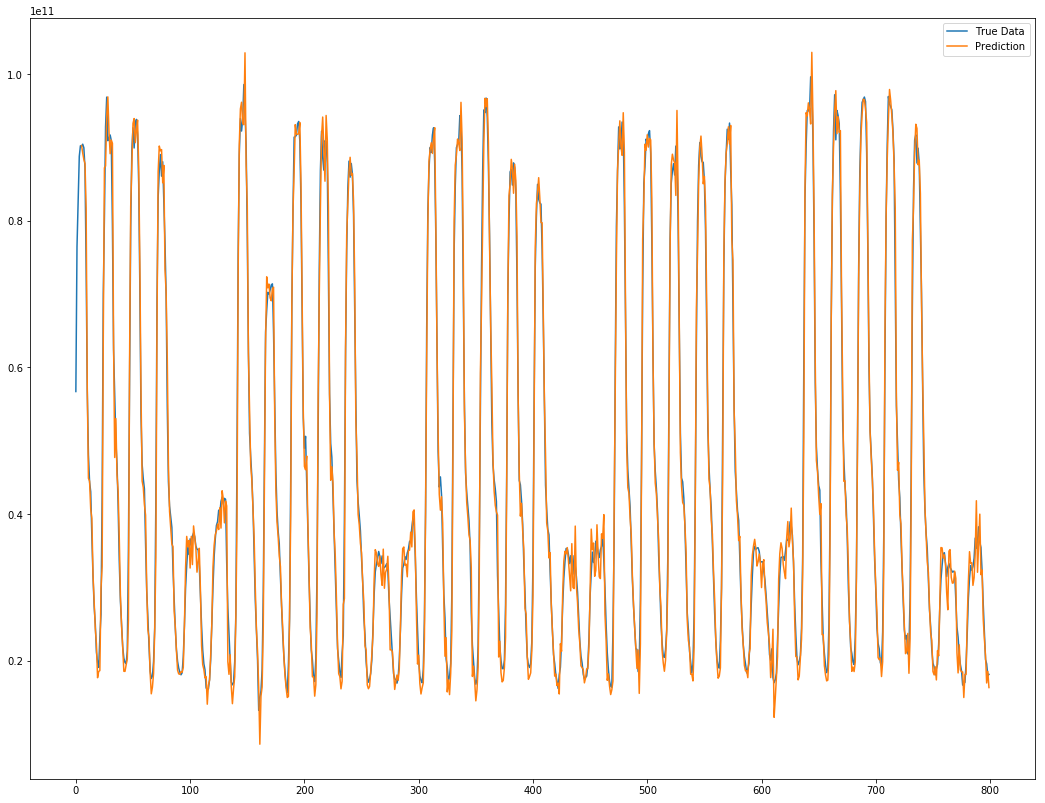

In [28]:
plot_results(train_predictions, train_data)

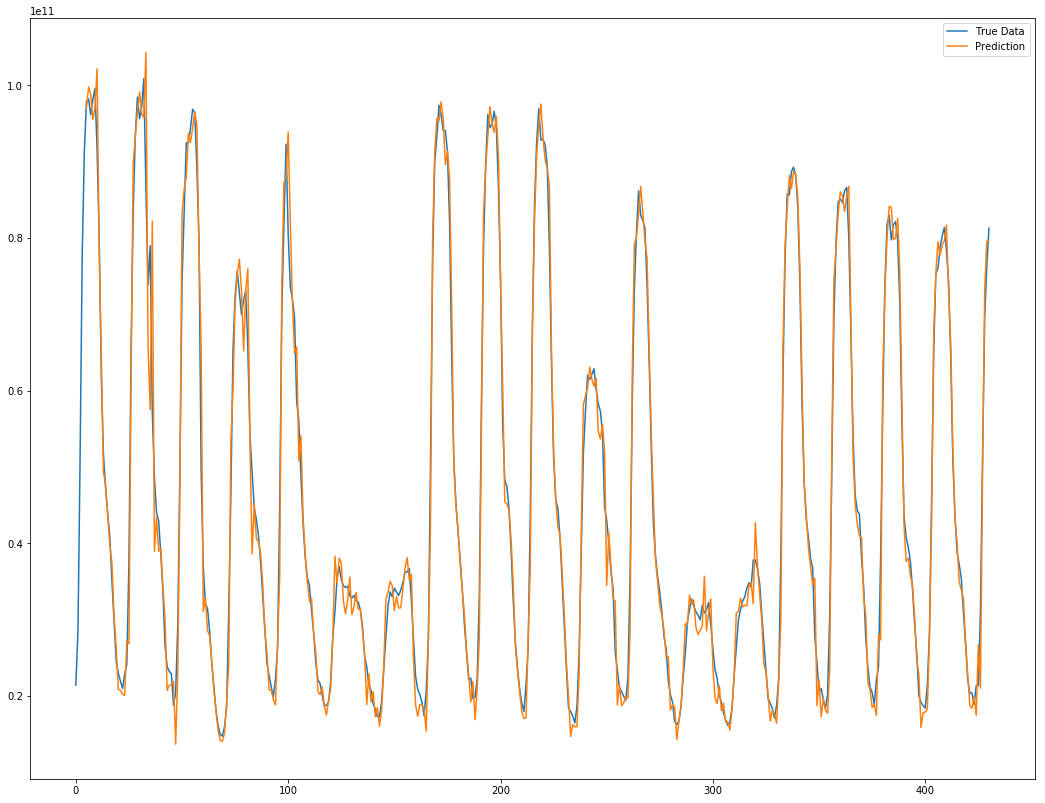

In [29]:
plot_results(test_predictions, test_data)

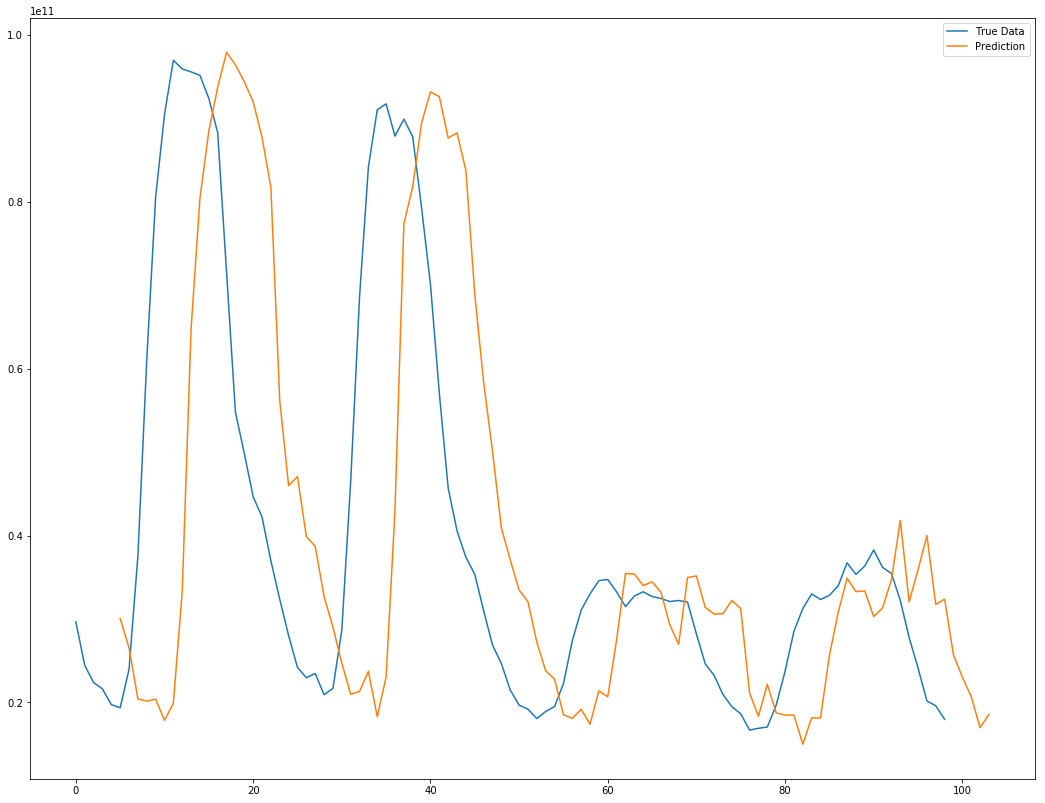

In [30]:
# zoom in on training predictions
plot_results(train_predictions[-100:-1], train_data[-100:-1])

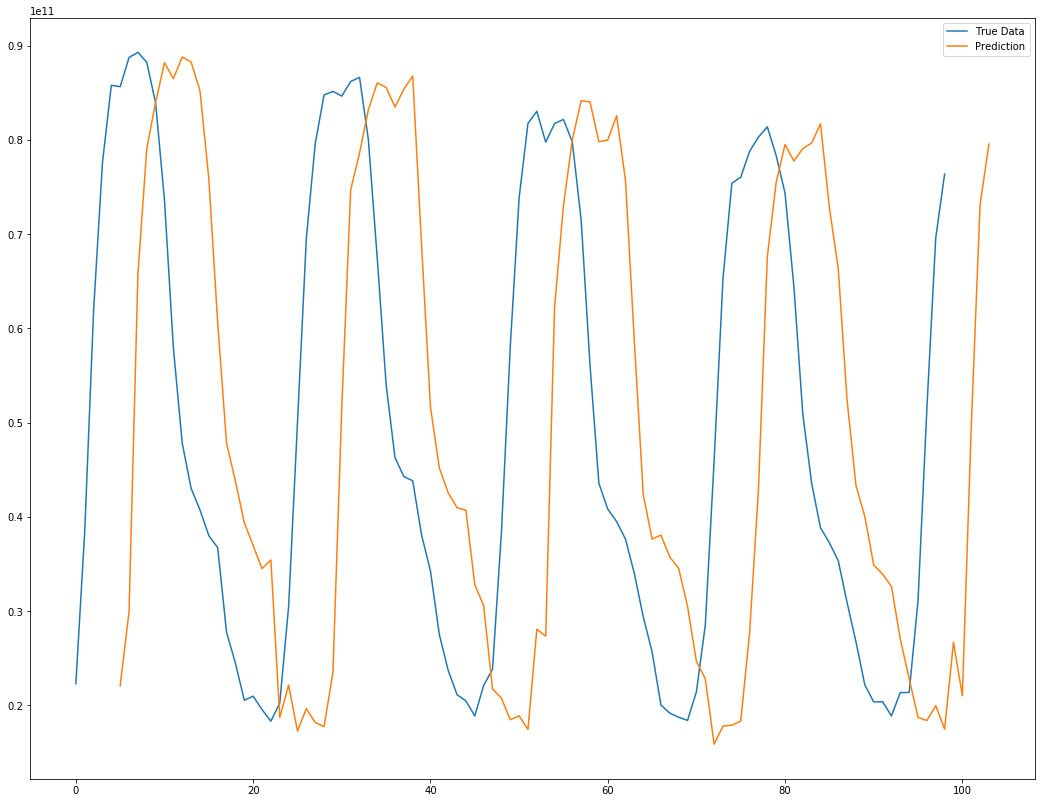

In [31]:
# zoom in on test predictions
plot_results(test_predictions[-100:-1], test_data[-100:-1])